In [35]:
import gurobipy as gp
import numpy as np
from flight_optimizer import *
import itertools

In [36]:
problem = FlightProblem.from_file("./data/d=0.5/p=20/h=7/DataCplex_density=0.5_p=20_h=7_test_4.dat")

In [37]:
# for flight in problem.flights:
#     flight.arrival_time += 30

In [38]:
def make_flight_graph(flights: list[Flight]):
    flight_graph = { i: [] for i in range(1, len(flights) + 1)}
    flight_graph_inv = { i: [] for i in range(1, len(flights) + 1)}

    for flight1, flight2 in itertools.combinations(flights, 2):
        if flight1.arrival_airport == flight2.departure_airport and flight1.arrival_time <= flight2.departure_time:
            flight_graph[flight1.id].append(flight2.id)
            flight_graph_inv[flight2.id].append(flight1.id)
        if flight2.arrival_airport == flight1.departure_airport and flight2.arrival_time <= flight1.departure_time:
            flight_graph[flight2.id].append(flight1.id)
            flight_graph_inv[flight1.id].append(flight2.id)

    return flight_graph, flight_graph_inv


In [39]:
flight_graph, flight_graph_inv = make_flight_graph(problem.flights)

In [40]:
sum(len(edges) for edges in flight_graph.values())

2134

In [41]:
model = gp.Model()

In [42]:
def inv_graph(graph):
    inv = {}

    for node, successors in graph.items():
        inv.setdefault(node, [])
        for succ in successors:
            inv.setdefault(succ, []).append(node)

    return inv
    

In [43]:
dependency_graph = {
    aircraft.id: {flight: out.copy() for flight, out in flight_graph.items()}
    for aircraft in problem.aircrafts
}

for aircraft in problem.aircrafts:
    dependency_graph[aircraft.id][-1] = [
        flight.id
        for flight in problem.flights
        if flight.departure_airport == aircraft.starting_airport
    ]

for aircraft, subgraph in dependency_graph.items():
    for flight in subgraph:
        subgraph[flight].append(-2)

In [44]:
dependency_graph_inv = {
    aircraft: inv_graph(subgraph)
    for aircraft, subgraph in dependency_graph.items()
}

In [45]:
vars = {
    aircraft: {
        flight: [model.addVar(vtype=gp.GRB.BINARY, name=f'x_{aircraft}_{flight}_{flight2}') for flight2 in out]
        for flight, out in subgraph.items()
    }
    for aircraft, subgraph in dependency_graph.items()
}

In [46]:
"""Objective"""
objective = 0

for aircraft, subgraph in dependency_graph.items():
    for flight_s, out in subgraph.items():
        for i, flight in enumerate(out):
            if flight == -2:
                continue
            objective += problem.flight_costs[flight-1, aircraft]*vars[aircraft][flight_s][i]

model.setObjective(objective, gp.GRB.MINIMIZE)


In [47]:
for flight in problem.flights:
    constraint = 0
    for aircraft in problem.aircrafts:
        for flight_p in dependency_graph_inv[aircraft.id][flight.id]:
            i = dependency_graph[aircraft.id][flight_p].index(flight.id)
            constraint += vars[aircraft.id][flight_p][i]

    model.addConstr(constraint == 1)

In [48]:
for flight in problem.flights:
    for aircraft in problem.aircrafts:
        preds = dependency_graph_inv[aircraft.id][flight.id]

        out = sum(vars[aircraft.id][flight.id])
        _in = 0

        for pred in preds:
            i = dependency_graph[aircraft.id][pred].index(flight.id)
            x = vars[aircraft.id][pred][i]
            _in += x

        model.addConstr(_in == out)
        


In [49]:
for aircraft in problem.aircrafts:
    model.addConstr(sum(vars[aircraft.id][-1]) <= 1)

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8845HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 4388 rows, 47309 columns and 133567 nonzeros
Model fingerprint: 0x152b768f
Variable types: 0 continuous, 47309 integer (47309 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+03, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 682 rows and 9082 columns
Presolve time: 0.59s
Presolved: 3706 rows, 38227 columns, 106078 nonzeros
Variable types: 0 continuous, 38227 integer (38227 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.07s

Solved with dual simplex

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 1.677097e+

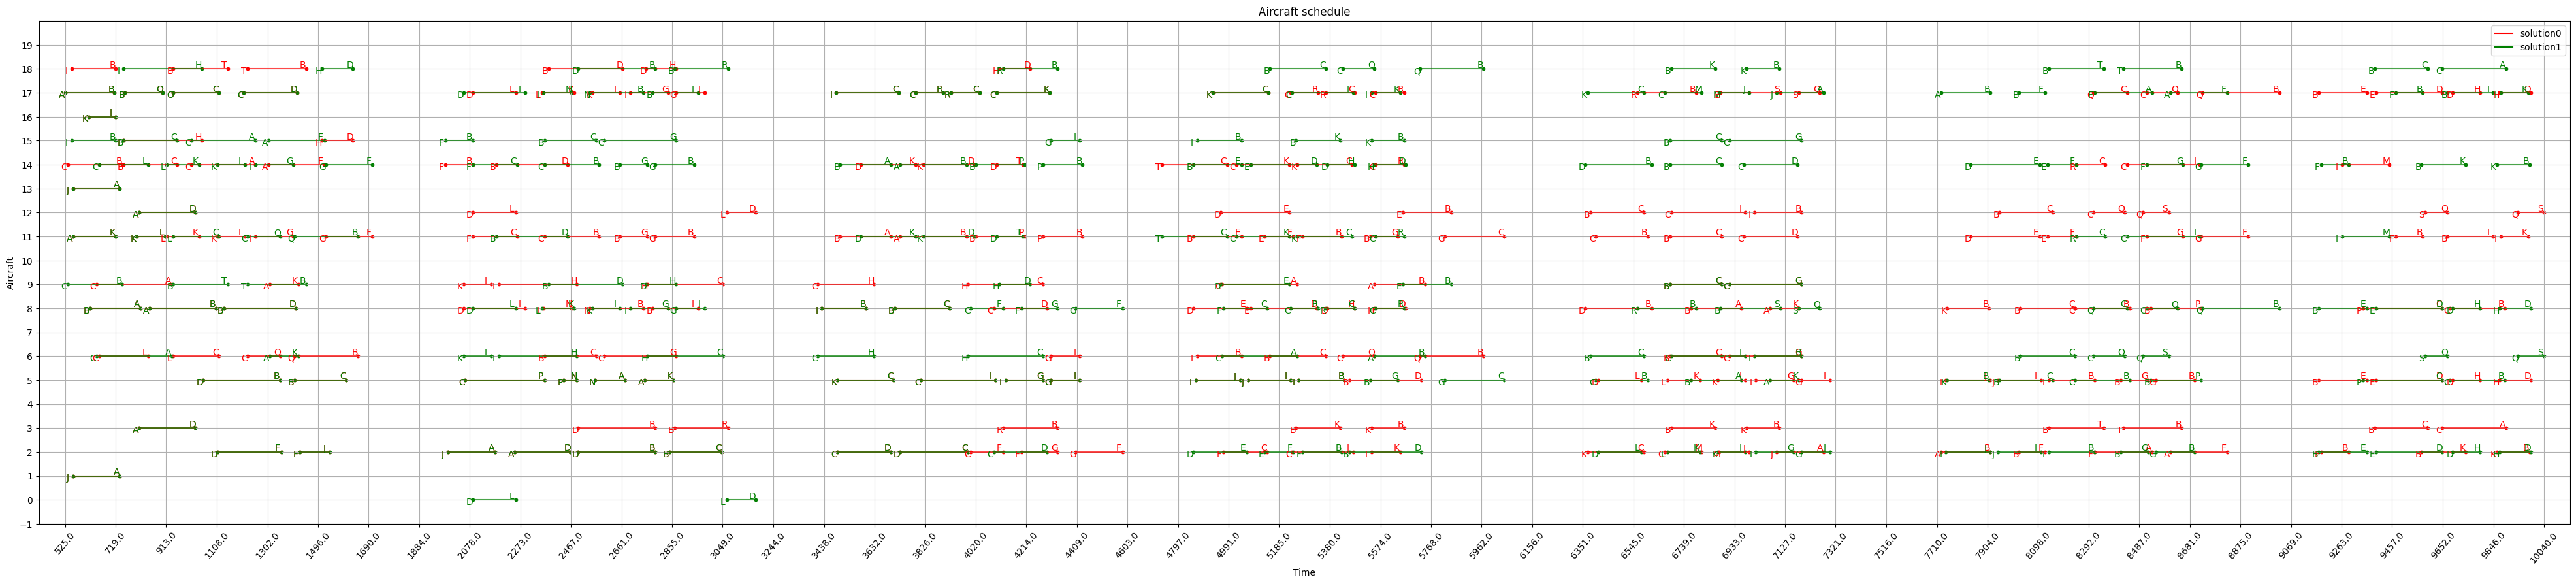

In [50]:
model.update()
model.optimize()

assignment = {
        aircraft: [ i for flight, out in subgraph.items() for i, x in zip(out, vars[aircraft][flight][:-1]) if x.x > 0.0]
        for aircraft, subgraph in dependency_graph.items() 
    }

found_solution = FlightSolution.from_assignment(assignment, problem)
cplx_solution = FlightSolution.from_file("./data/d=0.5/p=20/h=7/Optimal_Solution_density=0.5_p=20_h=7_test_4.txt", problem)
reporter = Reporter()
fig = reporter.plot_solution([found_solution, cplx_solution])

In [52]:
found_solution.cost - cplx_solution.cost

np.float64(-31.0)

In [54]:
solver = FlowSolver()
solution2 = solver.solve(problem)


In [55]:
solution2.cost - cplx_solution.cost

np.float64(49.0)

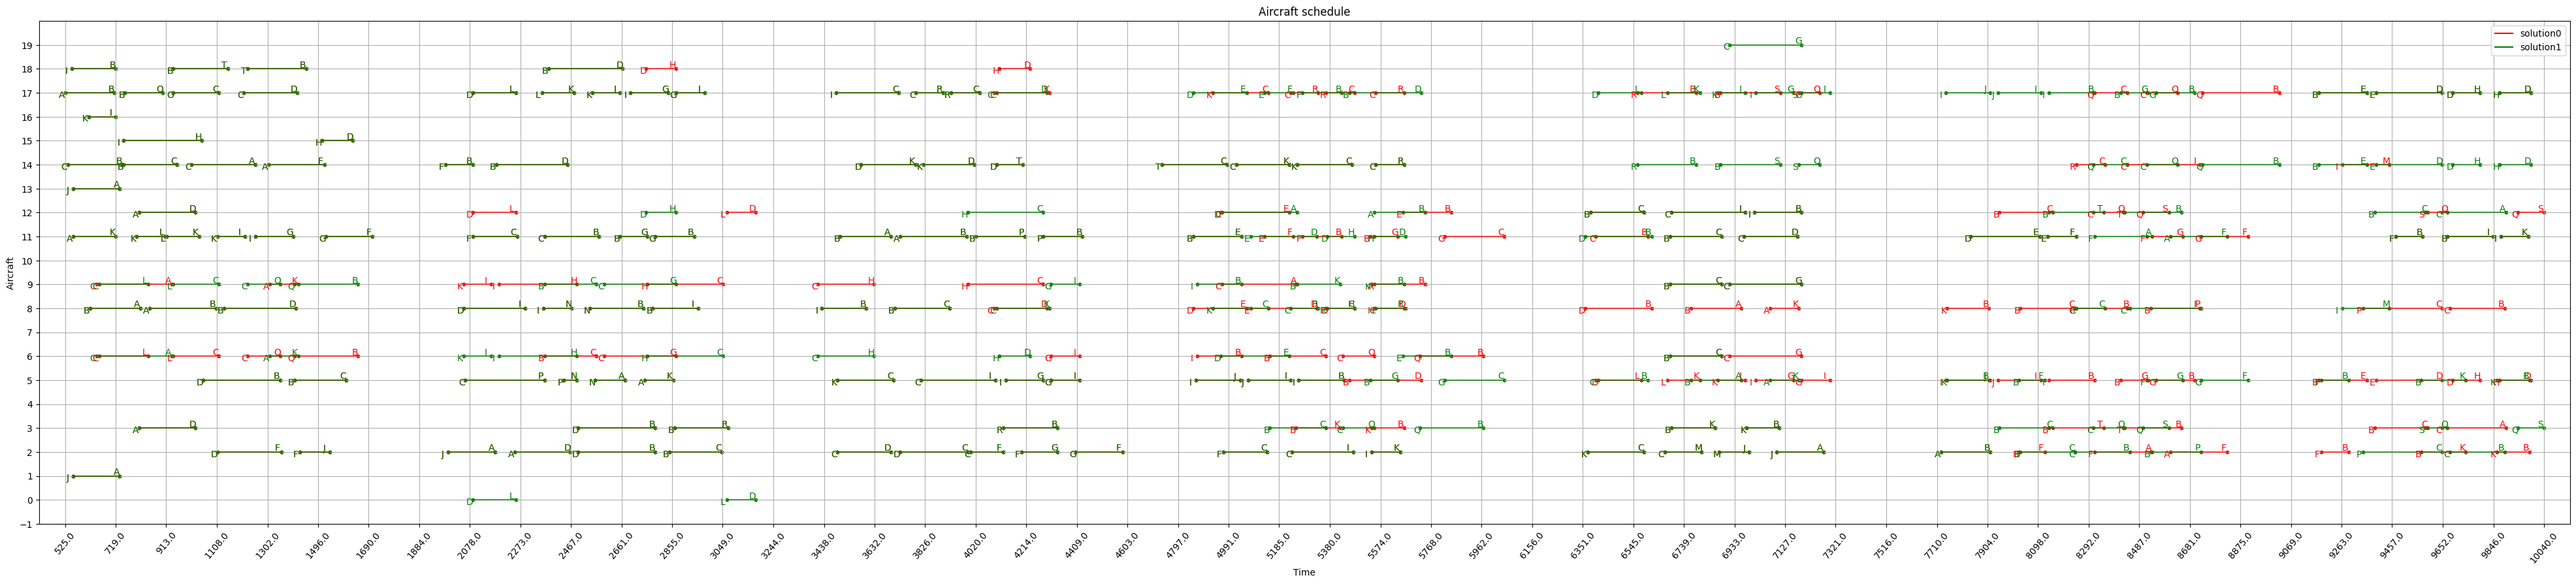

In [20]:
fig = reporter.plot_solution([found_solution, solution2])

In [ ]:
cplx_solution.cost

np.float64(1677128.0)

In [105]:
cplx_solution = FlightSolution.from_file("./data/d=0.5/p=10/h=7/Optimal_Solution_density=0.5_p=10_h=7_test_0.txt", problem)

cplx_assignment = {
    aircraft : [flight.id for flight in flights]
    for aircraft, flights in cplx_solution.assignment.items()
}

model.params.outputflag = 0
model.update()
model.optimize()

solutions = []
i = 0
while True:
    s = 0

    for aircraft, subgraph in vars.items():
        for flight, out in subgraph.items():
            for v in out:
                s += v.x * v

    model.addConstr(s <= len(problem.flights) - 1)
    
    assignment = {
        aircraft: [ i for flight, out in subgraph.items() for i, x in zip(out, vars[aircraft][flight]) if x.x > 0.0]
        for aircraft, subgraph in dependency_graph.items() 
    }

    found_solution = FlightSolution.from_assignment(assignment, problem)

    shared_items = {k: assignment[k] for k in assignment if k in cplx_assignment and assignment[k] == cplx_assignment[k]}
    if len(shared_items) == len(problem.aircrafts):
        break
    if found_solution.cost > cplx_solution.cost:
        print("not found")
        break
    
    solutions.append(found_solution)

    print(f'\rCurrently at: {i}', end='')
    i+=1

not found
